<a href="https://colab.research.google.com/github/Nikitha-Pillai/Pest-Detection-Model/blob/main/Pest4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Required Libraries
!pip install torch torchvision pycocotools scikit-learn albumentations

# Step 3: Import Libraries
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Class names
class_names = {
    0: "corn pests (superclass)",
    1: "army worm",
    2: "black cut worm",
    3: "grub",
    4: "mole cricket",
    5: "peach borer",
    6: "red spider mite"
}

# Dataset class with invalid box filtering
class PestDetectionDataset(Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.coco_dataset = CocoDetection(root=root, annFile=annFile)
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        img, target = self.coco_dataset[idx]
        img = np.array(img)
        boxes = []
        labels = []
        for t in target:
            if 'bbox' in t:
                x_min, y_min, width, height = t['bbox']
                x_max = x_min + width
                y_max = y_min + height
                # Debug: Check original boxes
                if width <= 0 or height <= 0:
                    print(f"Invalid original box at index {idx}: {t['bbox']}")
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(t['category_id'])

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels)

        if self.transform and len(boxes) > 0:
            transformed = self.transform(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
            # Filter invalid boxes after transformation
            valid_boxes = []
            valid_labels = []
            for box, label in zip(boxes, labels):
                x_min, y_min, x_max, y_max = box
                if x_max > x_min and y_max > y_min:
                    valid_boxes.append([x_min, y_min, x_max, y_max])
                    valid_labels.append(label)
                else:
                    print(f"Invalid transformed box at index {idx}: {box}")
            boxes = valid_boxes
            labels = valid_labels

        target = {}
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            target = {'boxes': boxes, 'labels': labels}
        else:
            target = {'boxes': torch.zeros((0, 4), dtype=torch.float32),
                      'labels': torch.zeros(0, dtype=torch.int64)}

        return img, target

    def __len__(self):
        return len(self.coco_dataset)

# Collate function
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Save confusion matrix function
def save_confusion_matrix(y_true, y_pred, save_path, title, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i] for i in range(len(class_names))],
                yticklabels=[class_names[i] for i in range(len(class_names))])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Training transforms with safeguards
train_transforms = A.Compose([
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.1),
    A.CLAHE(p=0.1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1.0, min_visibility=0.3, label_fields=['labels']))

# Load Training Dataset
train_dir = '/content/drive/My Drive/pest_detection/pest_img/train'
train_dataset = PestDetectionDataset(
    root=train_dir,
    annFile=os.path.join(train_dir, '_annotations.coco.json'),
    transform=train_transforms
)
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)
print(f"Number of training images: {len(train_dataset)}")

# Load Pretrained Model
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Optimizer and Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Load Checkpoint
checkpoint_dir = '/content/drive/My Drive/trial/'
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('C4checkpoint_epoch_') and f.endswith('.pth')]
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_epoch_')[1].split('.pth')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    print(f"Resuming training from {checkpoint_path}, epoch {start_epoch-1}, loss {best_loss}")
else:
    start_epoch = 0
    best_loss = float('inf')
    print("No checkpoint found, starting training from scratch.")

# Training Loop with Aggregate Confusion Matrix
num_epochs = 50
aggregate_interval = 10
print("Starting training loop...")

aggregate_true_labels = []
aggregate_pred_labels = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_train_loss = 0

    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_train_loss += losses.item()
        losses.backward()
        optimizer.step()

        if (i+1) % 10 == 0 or (i+1) == len(train_loader):
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Train Loss: {losses.item():.4f}")

    # Update learning rate
    lr_scheduler.step()

    # Calculate average loss
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Train Loss: {avg_train_loss:.4f}")

    # Evaluate on training data every 10 epochs
    if (epoch + 1) % aggregate_interval == 0 or (epoch + 1) == num_epochs:
        model.eval()
        with torch.no_grad():
            for images, targets in train_loader:
                images = [img.to(device) for img in images]
                predictions = model(images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                for target, pred in zip(targets, predictions):
                    true_labels = target['labels'].cpu().numpy()
                    pred_labels = pred['labels'].cpu().numpy()
                    scores = pred['scores'].cpu().numpy()
                    mask = scores > 0.5
                    pred_labels = pred_labels[mask]

                    if len(true_labels) > 0 and len(pred_labels) > 0:
                        if len(pred_labels) < len(true_labels):
                            pred_labels = np.pad(pred_labels, (0, len(true_labels) - len(pred_labels)),
                                                 mode='constant', constant_values=0)
                        elif len(pred_labels) > len(true_labels):
                            pred_labels = pred_labels[:len(true_labels)]
                        aggregate_true_labels.extend(true_labels)
                        aggregate_pred_labels.extend(pred_labels)

        if aggregate_true_labels and aggregate_pred_labels:
            start_epoch_range = max(1, epoch + 1 - aggregate_interval + 1)
            end_epoch_range = epoch + 1
            save_confusion_matrix(
                aggregate_true_labels, aggregate_pred_labels,
                f'/content/drive/My Drive/trial/aggregate_cm_epochs_{start_epoch_range}_to_{end_epoch_range}.png',
                f'Aggregate Training Confusion Matrix - Epochs {start_epoch_range} to {end_epoch_range}', class_names
            )
            print(f"Aggregate confusion matrix saved for epochs {start_epoch_range} to {end_epoch_range}")
            aggregate_true_labels = []  # Reset for next block
            aggregate_pred_labels = []

    # Save best model
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/trial/C4pest_detector_best.pth')
        print(f"New best model saved! Loss: {best_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % aggregate_interval == 0 or (epoch + 1) == num_epochs:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'loss': avg_train_loss,
        }, f'/content/drive/My Drive/trial/C4checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}")

# Save final model
torch.save(model.state_dict(), '/content/drive/My Drive/trial/C4pest_detector_final.pth')
print("Final model saved successfully!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 152MB/s]


Using device: cuda
Resuming training from /content/drive/My Drive/trial/C4checkpoint_epoch_40.pth, epoch 39, loss 0.08005382474989463
Starting training loop...
Epoch 41/50, Batch 10/780, Train Loss: 0.0553
Epoch 41/50, Batch 20/780, Train Loss: 0.1126
Epoch 41/50, Batch 30/780, Train Loss: 0.0637
Epoch 41/50, Batch 40/780, Train Loss: 0.1008
Epoch 41/50, Batch 50/780, Train Loss: 0.1230
Epoch 41/50, Batch 60/780, Train Loss: 0.0815
Epoch 41/50, Batch 70/780, Train Loss: 0.0917
Epoch 41/50, Batch 80/780, Train Loss: 0.0658
Epoch 41/50, Batch 90/780, Train Loss: 0.0535
Epoch 41/50, Batch 100/780, Train Loss: 0.0814
Epoch 41/50, Batch 110/780, Train Loss: 0.1371
Epoch 41/50, Batch 120/780, Train Loss: 0.0697
Epoch 41/50, Batch 130/780, Train Loss: 0.0504
Epoch 41/50, Batch 140/780, Train Loss: 0.0497
Epoch 41/50, Batch 150/780, Train Loss: 0.0737
Epoch 41/50, Batch 160/780, Train Loss: 0.0806
Epoch 41/50, Batch 170/780, Train Loss: 0.0350
Epoch 41/50, Batch 180/780, Train Loss: 0.0871
Epo

In [ ]:
import torch

# Path to your checkpoint file - updated to the pattern used for saving
checkpoint_path = '/content/drive/My Drive/trial/C4checkpoint_epoch_10.pth'  # Assuming you saved with this naming pattern

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Access the contents
epoch = checkpoint['epoch']
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
scheduler_state_dict = checkpoint['scheduler_state_dict']
loss = checkpoint['loss']

print(f"Loaded checkpoint from epoch {epoch} with loss {loss}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-d3e065d8f994>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


Loaded checkpoint from epoch 9 with loss 0.08062646865653686


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Required Libraries
!pip install torch torchvision pycocotools scikit-learn

# Step 3: Import Libraries and Load Validation Dataset
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Class names for clarity
class_names = {
    0: "corn pests (superclass)",
    1: "army worm",
    2: "black cut worm",
    3: "grub",
    4: "mole cricket",
    5: "peach borer",
    6: "red spider mite"
}

# Function to save confusion matrix
def save_confusion_matrix(y_true, y_pred, save_path, title, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i] for i in range(len(class_names))],
                yticklabels=[class_names[i] for i in range(len(class_names))])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Data Loading Function
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Load Validation Dataset
valid_dir = '/content/drive/My Drive/pest_detection/pest_img/valid'
valid_dataset = CocoDetection(root=valid_dir, annFile=os.path.join(valid_dir, '_annotations.coco.json'), transform=ToTensor())
print(f"Number of validation images: {len(valid_dataset)}")

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Step 4: Load Pretrained Model and Saved Weights
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
num_classes = 7  # 0 (superclass) + 6 pest classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_path = '/content/drive/My Drive/trial/C4pest_detector_best.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully!")
else:
    print("No saved model found. Using default weights.")

# Step 5: Move Model to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

# Step 6: Validation Loop with Corrected Confusion Matrix
print("Starting validation...")
model.eval()
total_val_loss = 0
all_true_labels = []
all_pred_labels = []

try:
    for i, (images, targets) in enumerate(valid_loader):
        images = [img.to(device) for img in images]
        processed_targets = []
        for t in targets:
            if isinstance(t, list) and len(t) > 0 and 'bbox' in t[0]:
                bboxes = torch.tensor([ann['bbox'] for ann in t], dtype=torch.float32, device=device)
                bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
                bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
                labels = torch.tensor([ann['category_id'] for ann in t], dtype=torch.int64, device=device)
                processed_targets.append({'boxes': bboxes, 'labels': labels})
            else:
                processed_targets.append({'boxes': torch.zeros((0, 4), device=device), 'labels': torch.zeros((0,), device=device)})

        with torch.no_grad():
            predictions = model(images)
            model.train()
            loss_dict = model(images, processed_targets)
            model.eval()
            val_losses = sum(loss for loss in loss_dict.values())
            total_val_loss += val_losses.item()

        # Collect true and predicted labels
        for target, pred in zip(processed_targets, predictions):
            true_labels = target['labels'].cpu().numpy()
            pred_labels = pred['labels'].cpu().numpy()
            scores = pred['scores'].cpu().numpy()
            mask = scores > 0.5
            pred_labels = pred_labels[mask]

            # Align lengths
            if len(pred_labels) < len(true_labels):
                pred_labels = np.pad(pred_labels, (0, len(true_labels) - len(pred_labels)), mode='constant', constant_values=0)
            pred_labels = pred_labels[:len(true_labels)]

            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)

        print(f"Batch {i+1}/{len(valid_loader)}, Validation Loss: {val_losses.item()}")

    avg_val_loss = total_val_loss / len(valid_loader)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    if all_true_labels and all_pred_labels:
        save_confusion_matrix(all_true_labels, all_pred_labels,
                              '/content/drive/My Drive/pest_detection/valid_cm_corrected.png',
                              'Validation Confusion Matrix (Corrected)', class_names)
    else:
        print("No valid labels for confusion matrix.")

except Exception as e:
    print(f"Validation crashed with error: {e}")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 158MB/s]


Model loaded successfully!
Using device: cuda
Starting validation...
Batch 1/780, Validation Loss: 0.24646730720996857
Batch 2/780, Validation Loss: 0.15449263155460358
Batch 3/780, Validation Loss: 0.4982104003429413
Batch 4/780, Validation Loss: 2.281116485595703
Batch 5/780, Validation Loss: 0.343045711517334
Batch 6/780, Validation Loss: 0.5766097903251648
Batch 7/780, Validation Loss: 0.3931530714035034
Batch 8/780, Validation Loss: 0.09313859790563583
Batch 9/780, Validation Loss: 0.7874125838279724
Batch 10/780, Validation Loss: 0.16839900612831116
Batch 11/780, Validation Loss: 0.19479192793369293
Batch 12/780, Validation Loss: 0.42847558856010437
Batch 13/780, Validation Loss: 0.34652701020240784
Batch 14/780, Validation Loss: 0.14515680074691772
Batch 15/780, Validation Loss: 0.3208867609500885
Batch 16/780, Validation Loss: 0.22595366835594177
Batch 17/780, Validation Loss: 0.1552051603794098
Batch 18/780, Validation Loss: 0.43031495809555054
Batch 19/780, Validation Loss: 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: 2: No such file or directory
Using device: cuda

Please upload a raw image for pest detection (ideally from your training set):


Saving BlackCutWorm-RWS2011xx.jpg to BlackCutWorm-RWS2011xx.jpg
Original image size: (876, 584)

Training Annotation Categories:
ID: 0, Name: corn-pests
ID: 1, Name: army worm
ID: 2, Name: black cutworm
ID: 3, Name: grub
ID: 4, Name: mole cricket
ID: 5, Name: peach borer
ID: 6, Name: red spider
Number of annotations: 4292
Transformed image tensor size: torch.Size([1, 3, 512, 512])

Testing with custom model:
Loaded custom weights from /content/drive/My Drive/trial/C4pest_detector_best.pth
Sample weight (sanity check): -0.3600
Custom Model Predictions:
Boxes: tensor([[102.4734, 122.5559, 394.9301, 367.7696],
        [ 66.7450, 173.9635, 442.3026, 492.3118],
        [123.2989,  93.7891, 377.9312, 316.4598]], device='cuda:0')
Labels: tensor([2, 2, 3], device='cuda:0')
Scores: tensor([0.9881, 0.3070, 0.2276], device='cuda:0')
Max confidence score: 0.9881


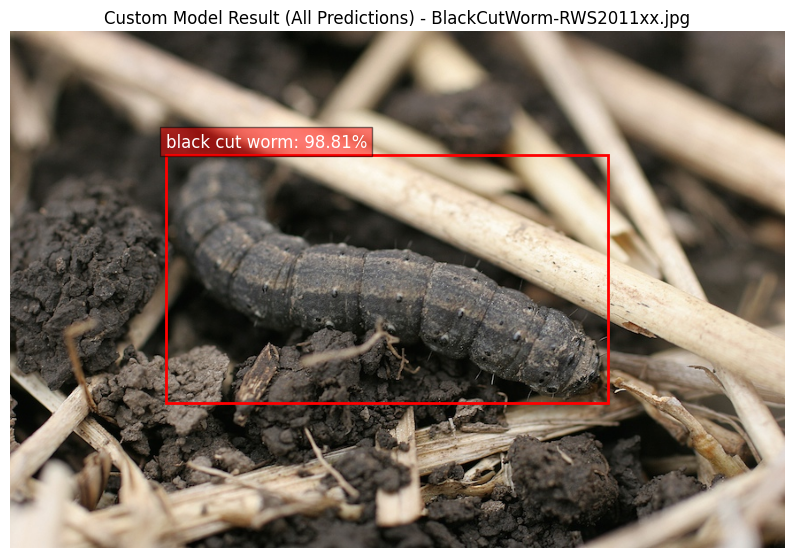

Result saved to: /content/drive/My Drive/trial/test_result.png


In [3]:
#corrected try check code
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Required Libraries
!pip install torch==2.0.1 torchvision==0.15.2 numpy<2 albumentations --no-cache-dir

# Step 3: Import Libraries
import os
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import numpy as np
import json  # For checking annotations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Class names for pest detection
class_names = {
    0: "corn pests (superclass)",
    1: "army worm",
    2: "black cut worm",
    3: "grub",
    4: "mole cricket",
    5: "peach borer",
    6: "red spider mite"
}

# Step 4: Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 5: Define Preprocessing Transform (Matching Training)
test_transforms = A.Compose([
    A.Resize(height=512, width=512),  # Match training size
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Match training normalization
    ToTensorV2()
])

# Step 6: Load Model Function
def load_model(weights_path=None):
    model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT" if not weights_path else None)
    num_classes = 7
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if weights_path and os.path.exists(weights_path):
        state_dict = torch.load(weights_path, map_location=device)
        model.load_state_dict(state_dict)
        print(f"Loaded custom weights from {weights_path}")
        print(f"Sample weight (sanity check): {state_dict['roi_heads.box_predictor.cls_score.weight'].sum().item():.4f}")
    else:
        print("Using default pretrained weights")

    model.to(device)
    model.eval()
    return model

# Step 7: Upload Image
print("\nPlease upload a raw image for pest detection (ideally from your training set):")
uploaded = files.upload()

if len(uploaded) == 0:
    print("No image uploaded. Exiting.")
    exit()

image_name = list(uploaded.keys())[0]
image_bytes = uploaded[image_name]
image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
print(f"Original image size: {image.size}")

# Step 8: Check Training Annotations (Optional Debugging)
ann_file = '/content/drive/My Drive/pest_detection/pest_img/train/_annotations.coco.json'
if os.path.exists(ann_file):
    with open(ann_file, 'r') as f:
        coco_data = json.load(f)
    print("\nTraining Annotation Categories:")
    for cat in coco_data['categories']:
        print(f"ID: {cat['id']}, Name: {cat['name']}")
    print(f"Number of annotations: {len(coco_data['annotations'])}")
    image_id = None
    for img in coco_data['images']:
        if img['file_name'] == image_name:
            image_id = img['id']
            break
    if image_id:
        anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
        print(f"Annotations for {image_name}:")
        for ann in anns:
            print(f"Category ID: {ann['category_id']}, BBox: {ann['bbox']}")

# Transform image (convert PIL to numpy for albumentations)
image_np = np.array(image)
transformed = test_transforms(image=image_np)
image_tensor = transformed['image'].to(device)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
print(f"Transformed image tensor size: {image_tensor.shape}")

# Step 9: Test with Custom Model
print("\nTesting with custom model:")
model = load_model('/content/drive/My Drive/trial/C4pest_detector_best.pth')
with torch.no_grad():
    prediction = model([image_tensor[0]])[0]

print("Custom Model Predictions:")
print(f"Boxes: {prediction['boxes']}")
print(f"Labels: {prediction['labels']}")
print(f"Scores: {prediction['scores']}")
if len(prediction['scores']) > 0:
    print(f"Max confidence score: {prediction['scores'].max().item():.4f}")
else:
    print("No predictions generated.")

# Visualize Custom Model Results (No Threshold Initially)
plt.figure(figsize=(10, 10))
plt.imshow(image_np)  # Use original numpy image before resizing for visualization
ax = plt.gca()
boxes = prediction['boxes'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()

# Scale boxes back to original image size
orig_height, orig_width = image_np.shape[:2]
model_height, model_width = 512, 512  # Training size
scale_x = orig_width / model_width
scale_y = orig_height / model_height

for box, label, score in zip(boxes, labels, scores):
  if score > 0.9:  # Apply threshold
    x_min, y_min, x_max, y_max = box
    x_min, x_max = x_min * scale_x, x_max * scale_x
    y_min, y_max = y_min * scale_y, y_max * scale_y
    width, height = x_max - x_min, y_max - y_min
    if width > 0 and height > 0:  # Validate box dimensions
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        pest_name = class_names.get(label, "unknown")
        plt.text(x_min, y_min - 10, f"{pest_name}: {score * 100:.2f}%",
                 color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    else:
        print(f"Skipping invalid box: {box}")

plt.axis('off')
plt.title(f"Custom Model Result (All Predictions) - {image_name}")
plt.show()

# Step 10: Save Custom Model Result with Threshold
save_path = '/content/drive/My Drive/trial/test_result.png'
plt.figure(figsize=(10, 10))
plt.imshow(image_np)  # Use original numpy image
ax = plt.gca()

for box, label, score in zip(boxes, labels, scores):
    if score > 0.9:  # Apply threshold
        x_min, y_min, x_max, y_max = box
        x_min, x_max = x_min * scale_x, x_max * scale_x
        y_min, y_max = y_min * scale_y, y_max * scale_y
        width, height = x_max - x_min, y_max - y_min
        if width > 0 and height > 0:
            rect = patches.Rectangle((x_min, y_min), width, height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            pest_name = class_names.get(label, "unknown")
            score_percent = score * 100
            plt.text(x_min, y_min - 10, f"{pest_name}: {score_percent:.2f}%",
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
        else:
            print(f"Skipping invalid box: {box}")

plt.axis('off')
plt.title(f"Custom Model Result - {image_name}")
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.close()
print(f"Result saved to: {save_path}")



